In [1]:
import os
import sys
import pickle

sys.path.append(os.path.abspath(os.path.join("../../..")))

import numpy as np
import tensorflow as tf
import torch

import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvariantNetwork, InvertibleNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer

from hnn_core import jones_2009_model, simulate_dipole, read_params

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

import bayesflow as bf
from bayesflow import computational_utilities as utils

matplotlib.rcParams["figure.dpi"] = 72

from hnn_core.utils import smooth_waveform

/Users/tianqicheng/opt/anaconda3/envs/2060/lib/python3.10/site-packages/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
--No graphics will be displayed.


In [2]:
RNG = np.random.default_rng(2022)

In [3]:
def prior():
    random_array = np.random.uniform(-4, 0, size=(3,))
#     random_array2 = np.random.uniform(0, 1, size=(1,))
#     random_array3 = np.random.uniform(0, 1, size=(1,))
#     combined_array = np.vstack((random_array1, random_array2, random_array3))
#     combined_array = np.squeeze(combined_array)
    return random_array

In [4]:
net = jones_2009_model()

In [5]:
def simulator(params, n_obs=1):
    
    avg = 2.7467337
    maxAbs = 196.12401
    
    res = np.empty((n_obs, 341))
    
    params = 10**params
    
    for i in range(n_obs):
        if n_obs==1:
            param0 = params[0]
            param1 = params[1]
            param2 = params[2]
        else:    
            param0 = params[0][i]
            param1 = params[1][i]
            param2 = params[2][i]
        
        net_sim = jones_2009_model()
    
    
        # add a distal evoked drive
        weights_ampa_d1 = {'L2_basket': 0.006562, 'L2_pyramidal': .000007,
                           'L5_pyramidal': param0}
        weights_nmda_d1 = {'L2_basket': 0.019482, 'L2_pyramidal': 0.004317,
                           'L5_pyramidal': 0.080074}
        synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                              'L5_pyramidal': 0.1}
        net_sim.add_evoked_drive(
            'evdist1', mu=63.53, sigma=3.85, numspikes=1, weights_ampa=weights_ampa_d1,
            weights_nmda=weights_nmda_d1, location='distal',
            synaptic_delays=synaptic_delays_d1, event_seed=274)


        # add two proximal drives
        weights_ampa_p1 = {'L2_basket': 0.08831, 'L2_pyramidal': 0.01525,
                           'L5_basket': 0.19934, 'L5_pyramidal': param1}
        synaptic_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                                'L5_basket': 1., 'L5_pyramidal': 1.}
        # all NMDA weights are zero; pass None explicitly
        net_sim.add_evoked_drive(
            'evprox1', mu=26.61, sigma=2.47, numspikes=1, weights_ampa=weights_ampa_p1,
            weights_nmda=None, location='proximal',
            synaptic_delays=synaptic_delays_prox, event_seed=544)

        # Second proximal evoked drive. NB: only AMPA weights differ from first
        weights_ampa_p2 = {'L2_basket': 0.000003, 'L2_pyramidal': 1.438840,
                           'L5_basket': 0.008958, 'L5_pyramidal': param2}
        # all NMDA weights are zero; omit weights_nmda (defaults to None)
        net_sim.add_evoked_drive(
            'evprox2', mu=137.12, sigma=8.33, numspikes=1,
            weights_ampa=weights_ampa_p2, location='proximal',
            synaptic_delays=synaptic_delays_prox, event_seed=814)

        dpl = simulate_dipole(net_sim, dt=0.5, tstop=170)
        
        
        # v2: scaling
        # v3: Center time series by taking the “grand mean” (mean of all entries in matrix) and subtract from each row
#         temp = dpl[0].data['agg']
        temp = dpl[0].copy().scale(3000).data['agg']
#         avg = np.mean(temp)
        temp = temp-avg
        
        # v4: Divide entire matrix by maximum of absolute value
#         maxAbs = np.max(np.abs(temp))
        temp = temp / maxAbs
        
#         # v5: smoothing 
        temp = smooth_waveform(temp, window_len=30, sfreq=1000.0 / 0.5)
        res[i] = temp
        

        
#         res[i] = dpl[0].copy().scale(3000).data['agg']
#         res[i] = dpl[0].copy().smooth(30).scale(3000).data['agg']
        

    # print(res.shape)
    return res

In [6]:
generative_model = bf.simulation.GenerativeModel(
    prior=prior, simulator=simulator, name="Generative Model: Training", simulator_is_batched=False
)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /Users/tianqicheng/opt/anaconda3/envs/2060/lib/python3.10/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...

INFO:root:Performing 2 pilot runs with the Generative Model: Training model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1, 341)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.



Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


In [7]:
summary_net = bf.networks.TimeSeriesTransformer(input_dim=341, summary_dim=3)  #10
inference_net = bf.networks.InvertibleNetwork(num_params=3, num_coupling_layers=3)
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, summary_loss_fun="MMD")
trainer = bf.trainers.Trainer(generative_model=generative_model, amortizer=amortizer)

INFO:root:Performing a consistency check with provided components...


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


INFO:root:Done.


In [8]:
x = torch.load('Aug29_data1000_3ERPDrives_no_preprocessing_exp_transform/x.pt')
theta = torch.load('Aug29_data1000_3ERPDrives_no_preprocessing_exp_transform/theta.pt')

In [9]:
x = np.array(x)
theta = np.array(theta)

In [10]:
x.shape

(1000, 341)

In [11]:
# scale
x = x * 3000

# Center time series by taking the “grand mean” (mean of all entries in matrix) and subtract from each row
avg = np.mean(x)
x = x - avg

# Divide entire matrix by maximum of absolute value
maxAbs = np.max(np.abs(x))
x = x / maxAbs

# Smoothing
for i in range(len(x)):
    x[i] = smooth_waveform(x[i], window_len=30, sfreq=1000.0 / 0.5)

In [12]:
avg

2.7467337

In [13]:
maxAbs

196.12401

In [14]:
x.shape

(1000, 341)

In [15]:
theta.shape

(1000, 3)

In [16]:
# Create dictionary that will be saved as a pickle file
presim_dict = dict.fromkeys(['prior_non_batchable_context', 'prior_batchable_context', 'prior_draws',
                             'sim_non_batchable_context', 'sim_batchable_context', 'sim_data'])

# Your parallel simulated data here
x_shape = x.shape
presim_dict['sim_data'] = x.reshape(x_shape[0], 1, x_shape[1])
presim_dict['prior_draws'] = theta
presim_dict = [presim_dict] # for some reason, the pickled file needs to be a list


# Save the dictionary as a pickle file, need to create folder called 'parallel_sim' first
with open('parallel_sim/presim_file_1.pkl', 'wb') as f:
    pickle.dump(presim_dict, f)

In [17]:
losses = trainer.train_from_presimulation(max_epochs=1000 ,presimulation_path='parallel_sim/', optimizer=tf.keras.optimizers.Adam())


Training epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 101:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 102:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 103:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 104:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 105:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 106:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 107:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 108:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 109:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 110:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 111:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 112:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 113:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 114:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 115:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 116:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 117:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 118:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 119:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 120:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 121:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 122:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 123:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 124:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 125:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 126:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 127:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 128:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 129:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 130:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 131:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 132:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 133:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 134:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 135:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 136:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 137:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 138:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 139:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 140:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 141:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 142:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 143:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 144:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 145:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 146:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 147:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 148:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 149:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 150:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 151:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 152:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 153:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 154:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 155:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 156:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 157:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 158:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 159:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 160:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 161:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 162:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 163:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 164:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 165:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 166:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 167:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 168:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 169:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 170:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 171:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 172:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 173:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 174:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 175:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 176:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 177:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 178:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 179:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 180:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 181:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 182:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 183:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 184:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 185:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 186:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 187:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 188:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 189:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 190:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 191:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 192:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 193:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 194:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 195:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 196:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 197:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 198:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 199:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 200:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 201:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 202:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 203:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 204:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 205:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 206:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 207:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 208:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 209:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 210:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 211:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 212:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 213:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 214:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 215:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 216:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 217:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 218:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 219:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 220:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 221:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 222:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 223:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 224:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 225:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 226:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 227:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 228:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 229:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 230:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 231:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 232:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 233:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 234:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 235:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 236:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 237:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 238:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 239:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 240:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 241:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 242:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 243:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 244:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 245:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 246:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 247:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 248:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 249:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 250:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 251:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 252:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 253:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 254:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 255:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 256:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 257:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 258:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 259:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 260:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 261:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 262:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 263:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 264:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 265:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 266:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 267:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 268:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 269:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 270:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 271:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 272:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 273:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 274:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 275:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 276:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 277:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 278:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 279:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 280:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 281:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 282:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 283:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 284:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 285:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 286:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 287:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 288:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 289:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 290:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 291:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 292:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 293:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 294:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 295:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 296:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 297:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 298:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 299:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 300:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 301:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 302:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 303:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 304:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 305:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 306:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 307:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 308:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 309:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 310:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 311:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 312:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 313:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 314:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 315:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 316:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 317:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 318:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 319:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 320:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 321:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 322:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 323:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 324:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 325:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 326:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 327:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 328:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 329:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 330:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 331:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 332:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 333:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 334:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 335:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 336:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 337:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 338:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 339:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 340:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 341:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 342:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 343:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 344:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 345:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 346:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 347:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 348:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 349:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 350:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 351:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 352:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 353:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 354:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 355:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 356:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 357:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 358:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 359:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 360:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 361:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 362:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 363:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 364:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 365:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 366:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 367:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 368:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 369:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 370:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 371:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 372:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 373:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 374:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 375:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 376:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 377:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 378:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 379:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 380:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 381:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 382:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 383:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 384:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 385:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 386:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 387:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 388:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 389:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 390:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 391:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 392:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 393:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 394:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 395:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 396:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 397:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 398:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 399:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 400:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 401:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 402:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 403:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 404:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 405:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 406:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 407:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 408:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 409:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 410:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 411:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 412:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 413:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 414:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 415:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 416:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 417:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 418:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 419:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 420:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 421:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 422:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 423:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 424:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 425:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 426:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 427:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 428:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 429:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 430:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 431:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 432:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 433:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 434:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 435:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 436:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 437:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 438:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 439:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 440:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 441:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 442:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 443:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 444:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 445:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 446:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 447:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 448:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 449:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 450:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 451:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 452:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 453:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 454:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 455:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 456:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 457:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 458:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 459:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 460:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 461:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 462:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 463:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 464:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 465:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 466:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 467:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 468:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 469:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 470:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 471:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 472:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 473:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 474:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 475:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 476:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 477:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 478:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 479:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 480:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 481:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 482:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 483:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 484:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 485:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 486:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 487:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 488:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 489:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 490:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 491:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 492:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 493:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 494:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 495:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 496:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 497:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 498:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 499:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 500:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 501:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 502:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 503:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 504:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 505:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 506:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 507:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 508:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 509:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 510:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 511:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 512:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 513:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 514:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 515:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 516:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 517:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 518:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 519:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 520:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 521:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 522:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 523:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 524:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 525:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 526:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 527:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 528:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 529:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 530:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 531:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 532:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 533:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 534:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 535:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 536:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 537:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 538:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 539:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 540:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 541:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 542:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 543:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 544:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 545:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 546:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 547:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 548:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 549:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 550:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 551:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 552:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 553:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 554:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 555:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 556:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 557:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 558:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 559:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 560:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 561:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 562:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 563:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 564:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 565:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 566:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 567:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 568:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 569:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 570:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 571:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 572:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 573:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 574:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 575:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 576:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 577:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 578:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 579:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 580:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 581:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 582:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 583:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 584:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 585:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 586:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 587:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 588:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 589:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 590:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 591:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 592:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 593:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 594:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 595:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 596:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 597:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 598:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 599:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 600:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 601:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 602:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 603:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 604:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 605:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 606:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 607:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 608:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 609:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 610:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 611:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 612:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 613:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 614:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 615:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 616:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 617:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 618:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 619:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 620:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 621:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 622:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 623:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 624:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 625:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 626:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 627:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 628:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 629:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 630:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 631:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 632:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 633:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 634:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 635:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 636:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 637:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 638:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 639:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 640:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 641:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 642:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 643:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 644:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 645:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 646:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 647:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 648:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 649:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 650:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 651:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 652:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 653:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 654:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 655:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 656:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 657:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 658:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 659:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 660:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 661:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 662:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 663:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 664:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 665:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 666:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 667:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 668:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 669:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 670:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 671:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 672:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 673:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 674:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 675:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 676:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 677:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 678:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 679:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 680:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 681:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 682:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 683:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 684:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 685:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 686:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 687:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 688:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 689:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 690:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 691:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 692:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 693:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 694:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 695:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 696:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 697:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 698:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 699:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 700:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 701:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 702:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 703:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 704:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 705:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 706:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 707:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 708:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 709:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 710:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 711:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 712:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 713:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 714:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 715:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 716:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 717:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 718:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 719:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 720:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 721:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 722:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 723:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 724:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 725:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 726:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 727:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 728:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 729:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 730:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 731:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 732:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 733:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 734:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 735:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 736:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 737:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 738:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 739:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 740:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 741:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 742:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 743:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 744:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 745:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 746:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 747:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 748:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 749:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 750:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 751:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 752:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 753:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 754:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 755:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 756:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 757:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 758:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 759:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 760:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 761:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 762:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 763:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 764:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 765:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 766:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 767:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 768:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 769:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 770:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 771:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 772:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 773:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 774:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 775:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 776:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 777:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 778:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 779:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 780:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 781:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 782:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 783:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 784:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 785:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 786:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 787:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 788:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 789:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 790:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 791:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 792:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 793:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 794:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 795:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 796:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 797:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 798:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 799:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 800:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 801:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 802:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 803:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 804:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 805:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 806:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 807:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 808:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 809:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 810:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 811:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 812:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 813:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 814:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 815:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 816:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 817:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 818:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 819:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 820:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 821:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 822:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 823:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 824:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 825:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 826:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 827:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 828:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 829:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 830:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 831:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 832:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 833:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 834:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 835:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 836:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 837:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 838:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 839:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 840:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 841:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 842:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 843:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 844:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 845:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 846:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 847:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 848:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 849:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 850:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 851:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 852:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 853:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 854:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 855:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 856:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 857:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 858:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 859:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 860:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 861:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 862:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 863:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 864:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 865:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 866:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 867:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 868:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 869:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 870:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 871:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 872:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 873:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 874:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 875:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 876:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 877:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 878:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 879:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 880:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 881:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 882:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 883:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 884:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 885:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 886:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 887:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 888:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 889:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 890:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 891:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 892:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 893:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 894:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 895:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 896:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 897:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 898:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 899:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 900:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 901:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 902:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 903:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 904:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 905:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 906:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 907:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 908:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 909:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 910:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 911:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 912:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 913:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 914:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 915:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 916:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 917:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 918:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 919:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 920:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 921:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 922:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 923:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 924:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 925:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 926:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 927:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 928:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 929:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 930:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 931:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 932:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 933:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 934:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 935:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 936:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 937:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 938:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 939:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 940:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 941:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 942:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 943:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 944:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 945:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 946:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 947:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 948:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 949:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 950:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 951:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 952:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 953:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 954:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 955:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 956:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 957:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 958:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 959:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 960:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 961:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 962:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 963:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 964:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 965:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 966:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 967:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 968:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 969:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 970:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 971:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 972:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 973:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 974:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 975:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 976:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 977:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 978:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 979:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 980:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 981:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 982:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 983:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 984:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 985:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 986:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 987:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 988:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 989:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 990:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 991:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 992:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 993:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 994:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 995:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 996:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 997:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 998:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 999:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 1000:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
losses

,Loss,W.Decay
0,14.362765,0.822048
1,19.410067,0.806924
2,16.760113,0.796277
3,14.000216,0.786801
4,11.414811,0.778039
...,...,...
995,0.782097,0.179129
996,0.798313,0.179221
997,0.772982,0.179291
998,0.660337,0.179271


<AxesSubplot: >

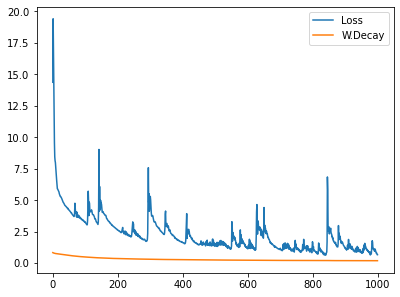

In [19]:
losses.plot()

## set reference_data

In [20]:
shape = x.shape
x = x.reshape(shape[0], 1, shape[1])
x.shape

(1000, 1, 341)

In [21]:
reference_data = {}
reference_data['summary_conditions'] = x
reference_data['direct_conditions'] = None
reference_data['parameters'] = theta

## One Actual HNN simulation output (this should not be mispecified)

In [22]:
import math

In [23]:
data_HNN = simulator(params=np.array((math.log10(0.142300), math.log10(0.00865), math.log10(0.684013))))

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


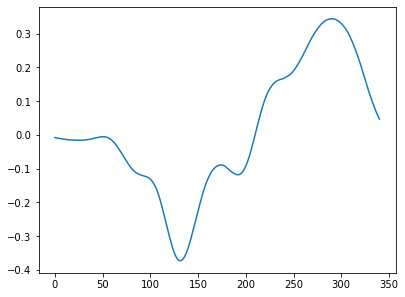

In [24]:
plt.plot(data_HNN.flatten().T)
plt.show()

In [25]:
shape = data_HNN.shape
data_HNN = data_HNN.reshape(shape[0], 1, shape[1])
data_HNN.shape

(1, 1, 341)

In [26]:
observed_data_HNN = {}
observed_data_HNN['summary_conditions'] = data_HNN
observed_data_HNN['direct_conditions'] = None
observed_data_HNN['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])

In [27]:
summary_statistics = trainer.amortizer.summary_net(x)
summary_statistics_obs = trainer.amortizer.summary_net(data_HNN)

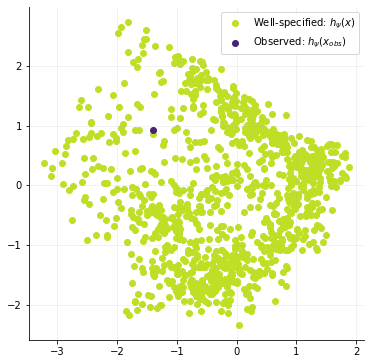

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = cm.viridis(np.linspace(0.1, 0.9, 2))
ax.scatter(summary_statistics[:, 0], summary_statistics[:, 1], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
ax.scatter(
    summary_statistics_obs[:, 0], summary_statistics_obs[:, 1], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
)
ax.legend()
ax.grid(alpha=0.2)
plt.gca().set_aspect("equal")
sns.despine(ax=ax)

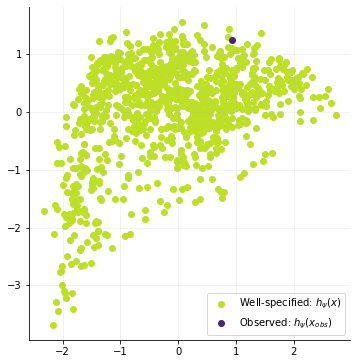

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = cm.viridis(np.linspace(0.1, 0.9, 2))
ax.scatter(summary_statistics[:, 1], summary_statistics[:, 2], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
ax.scatter(
    summary_statistics_obs[:, 1], summary_statistics_obs[:, 2], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
)
ax.legend()
ax.grid(alpha=0.2)
plt.gca().set_aspect("equal")
sns.despine(ax=ax)

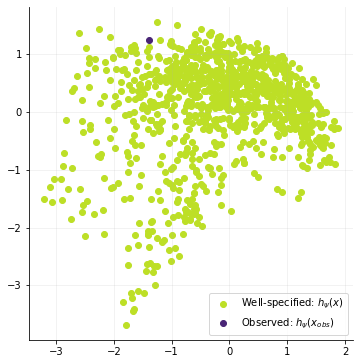

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = cm.viridis(np.linspace(0.1, 0.9, 2))
ax.scatter(summary_statistics[:, 0], summary_statistics[:, 2], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
ax.scatter(
    summary_statistics_obs[:, 0], summary_statistics_obs[:, 2], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
)
ax.legend()
ax.grid(alpha=0.2)
plt.gca().set_aspect("equal")
sns.despine(ax=ax)

In [31]:
import pandas as pd

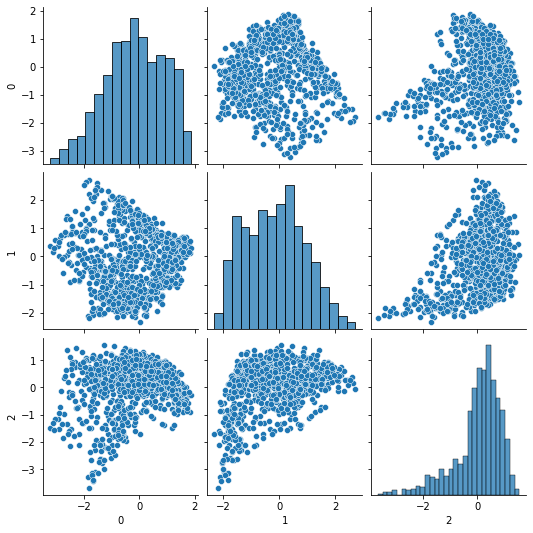

In [32]:
sns.pairplot(pd.DataFrame(summary_statistics))

  0%|          | 0/500 [00:00<?, ?it/s]

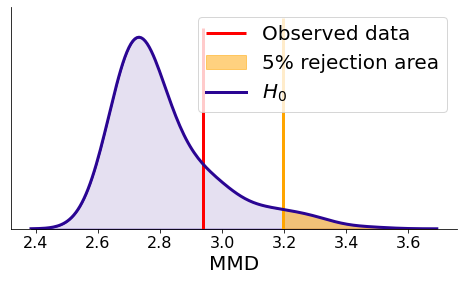

In [33]:
# 1000 simulated data sets from the well-specified model from training (for reference)

# Actual HNN simulation output (this should not be mispecified)

MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data_HNN, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

## 10 Actual HNN simulation outputs (this should not be mispecified)

In [172]:
def ten_priors(seed=222):
    if seed is not None:
        np.random.seed(seed)
        
    random_array1 = np.random.uniform(-4, 0, size=(10,3))
#     random_array2 = np.random.uniform(0, 1, size=(10,))
#     random_array3 = np.random.uniform(0, 1, size=(10,))
#     combined_array = np.vstack((random_array1, random_array2, random_array3))
#     combined_array = np.squeeze(combined_array)
    return random_array1.T

In [173]:
ten_params = ten_priors(0)
ten_params.shape

(3, 10)

In [174]:
ten_data_HNN = simulator(params=ten_params, n_obs=10)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEUR

In [175]:
ten_data_HNN.shape

(10, 341)

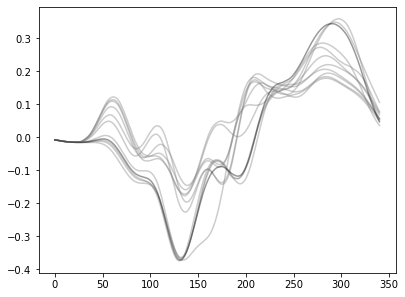

In [176]:
plt.plot(ten_data_HNN.T, color='gray', alpha=0.4)
plt.plot(data_HNN.reshape(341,).T, color='black', alpha=0.4)

In [177]:
shape = ten_data_HNN.shape
ten_data_HNN = ten_data_HNN.reshape(shape[0], 1, shape[1])
ten_data_HNN.shape

(10, 1, 341)

In [178]:
observed_ten_data_HNN = {}
observed_ten_data_HNN['summary_conditions'] = ten_data_HNN
observed_ten_data_HNN['direct_conditions'] = None
observed_ten_data_HNN['parameters'] = ten_params.T

  0%|          | 0/500 [00:00<?, ?it/s]

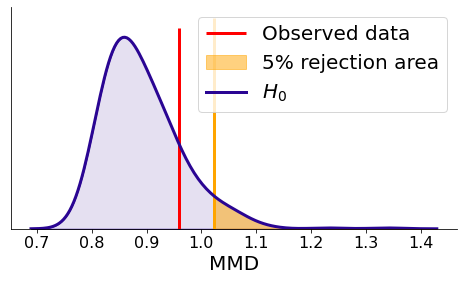

In [179]:
# 1000 simulated data sets from the well-specified model from training (for reference)

# Actual HNN simulation output (this should not be mispecified)

MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_ten_data_HNN, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

## Flat line/constant values (should be mispecificied)

In [42]:
# all 0

data_flat0 = np.zeros(shape=(1,1,341))
observed_data_flat0 = {}
observed_data_flat0['summary_conditions'] = data_flat0
observed_data_flat0['direct_conditions'] = None
observed_data_flat0['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])

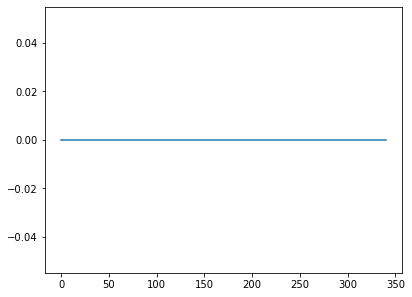

In [43]:
plt.plot(data_flat0.flatten().T)
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

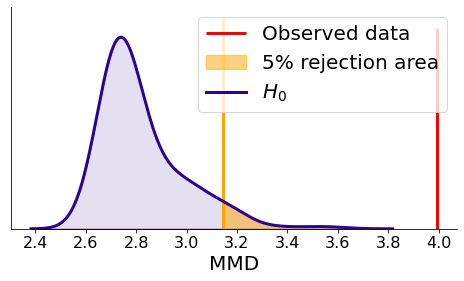

In [44]:
MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data_flat0, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

In [45]:
# all 0.015

data_flat = np.ones(shape=(1,1,341))*0.015
observed_data_flat = {}
observed_data_flat['summary_conditions'] = data_flat
observed_data_flat['direct_conditions'] = None
observed_data_flat['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])

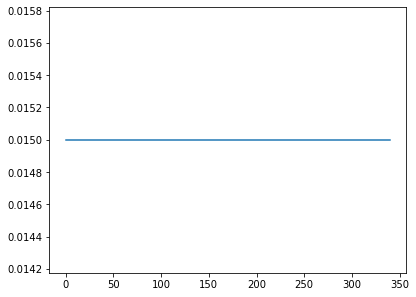

In [46]:
plt.plot(data_flat.flatten().T)
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

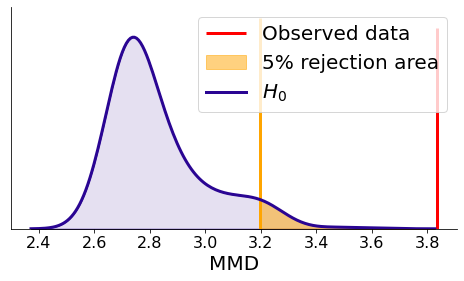

In [47]:
MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data_flat, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

In [48]:
# all 1

data_flat_2 = np.ones(shape=(1,1,341))
observed_data_flat_2 = {}
observed_data_flat_2['summary_conditions'] = data_flat_2
observed_data_flat_2['direct_conditions'] = None
observed_data_flat_2['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])

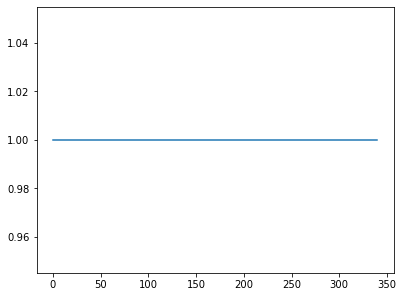

In [49]:
plt.plot(data_flat_2.flatten().T)
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

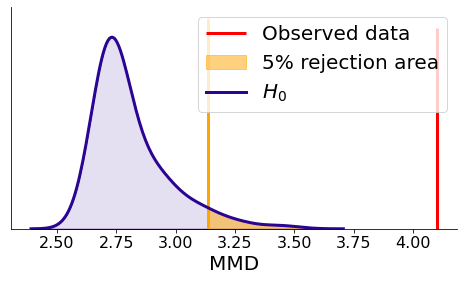

In [50]:
MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data_flat_2, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

## Flat line with gaussian noise (try different values of increasing noise amplitude)

In [51]:
# Gaussian noise

np.random.seed(666)

noise1 = np.random.normal(loc=0, scale=0, size=(341,))
noise2 = np.random.normal(loc=0, scale=0.001, size=(341,))
noise3 = np.random.normal(loc=0, scale=0.01, size=(341,)) #
noise4 = np.random.normal(loc=0, scale=0.1, size=(341,)) #
noise5 = np.random.normal(loc=0, scale=0.5, size=(341,)) #
noise6 = np.random.normal(loc=0, scale=1, size=(341,)) #
noise7 = np.random.normal(loc=0, scale=1.5, size=(341,)) #

noises = [noise1, noise2, noise3, noise4, noise5, noise6, noise7]
noise_names = ['noise_0', 'noise_0.001', 'noise_0.01', 'noise_0.1', 'noise_0.5', 'noise_1', 'noise_1.5']

noise_0


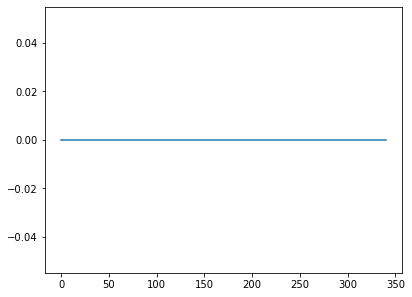

noise_0.001


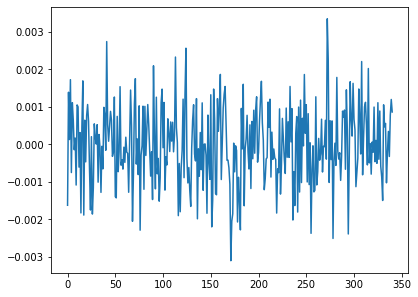

noise_0.01


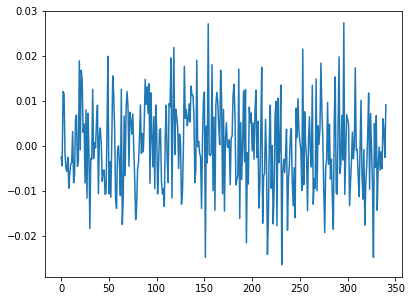

noise_0.1


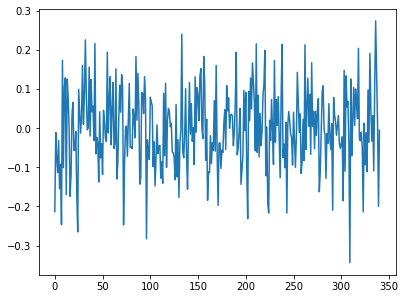

noise_0.5


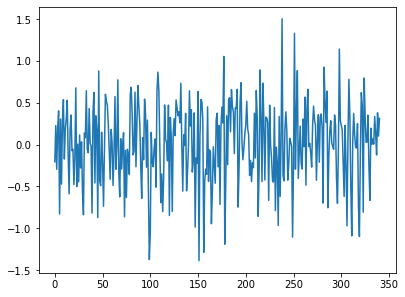

noise_1


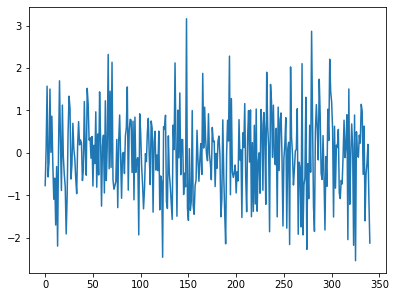

noise_1.5


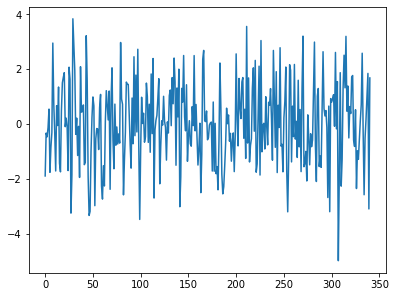

In [52]:
for noise, noise_name in zip(noises, noise_names):
    
    print(noise_name)
    
    data_flat_noise = data_flat0 + noise
    plt.plot(data_flat_noise.flatten().T)
    plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

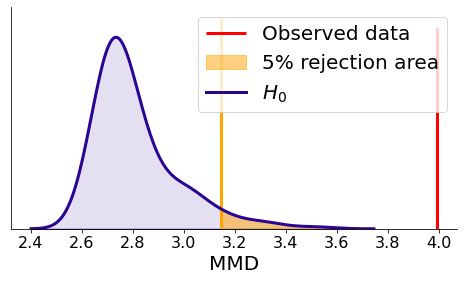

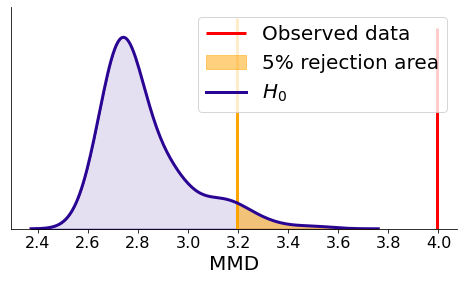

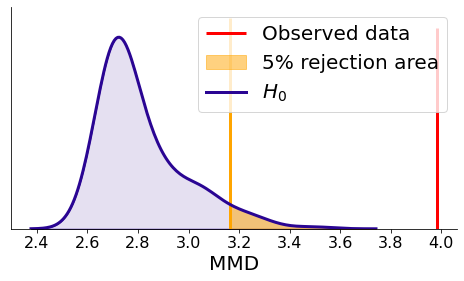

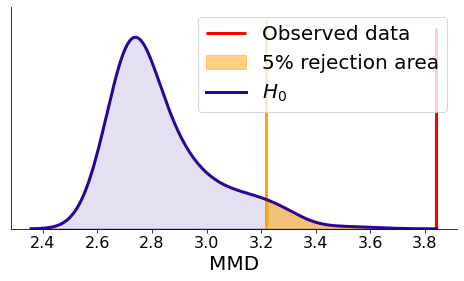

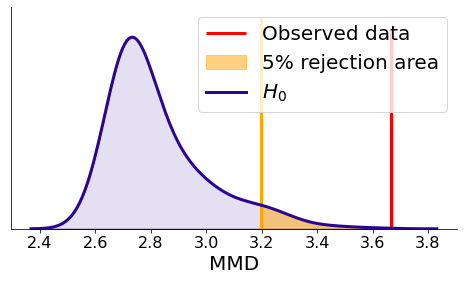

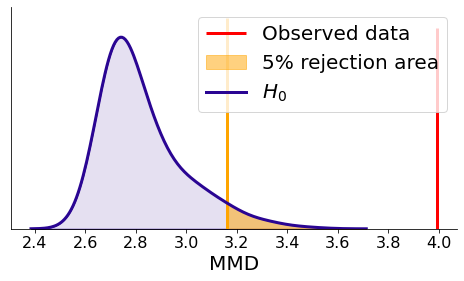

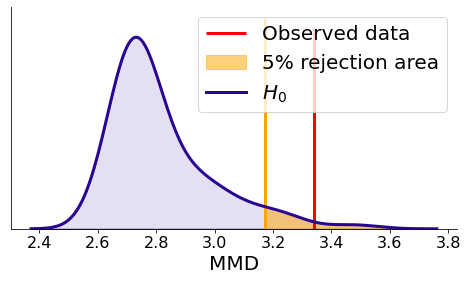

In [53]:
for noise, noise_name in zip(noises, noise_names):
    
    # print(noise_names)
    
    data_flat_noise = data_flat0 + noise
    # plt.plot(data_HNN_noise.flatten().T)
    # plt.show()
    
    observed_data_flat_noise = {}
    observed_data_flat_noise['summary_conditions'] = data_flat_noise
    observed_data_flat_noise['direct_conditions'] = None
    observed_data_flat_noise['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])
    
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(observed_data_flat_noise, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True)
    _ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
    

#     plt.savefig(f'hypothesis_test_figures/flat_zeros_data_with{noise_name}.png')
    # plt.close()

## One Actual HNN simulations with increasing noise

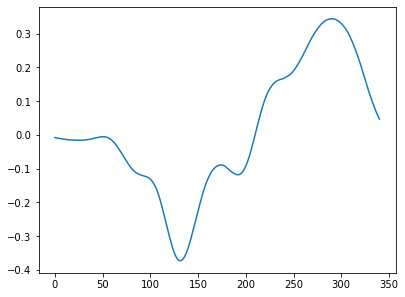

In [54]:
data_HNN_noise = data_HNN
plt.plot(data_HNN_noise.flatten().T)
plt.show()

In [55]:
# # Gaussian noise

# np.random.seed(666)

# noise1 = np.random.normal(loc=0, scale=0, size=(341,))
# noise2 = np.random.normal(loc=0, scale=0.05, size=(341,))
# noise3 = np.random.normal(loc=0, scale=0.1, size=(341,)) #
# noise4 = np.random.normal(loc=0, scale=0.2, size=(341,)) #
# noise5 = np.random.normal(loc=0, scale=0.3, size=(341,)) #
# noise6 = np.random.normal(loc=0, scale=0.5, size=(341,)) #
# noise7 = np.random.normal(loc=0, scale=1.0, size=(341,)) #

# noises = [noise1, noise2, noise3, noise4, noise5, noise6, noise7]
# noise_names = ['noise_0', 'noise_0.05', 'noise_0.1', 'noise_0.2', 'noise_0.3', 'noise_0.5', 'noise_1']

noise_0


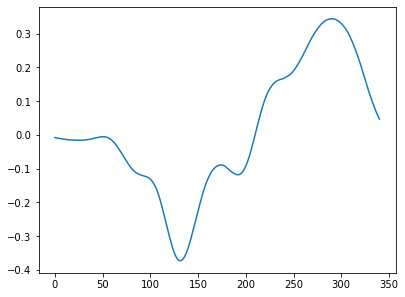

noise_0.001


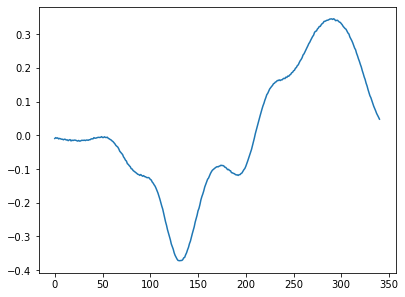

noise_0.01


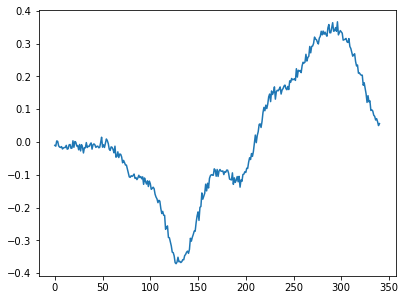

noise_0.1


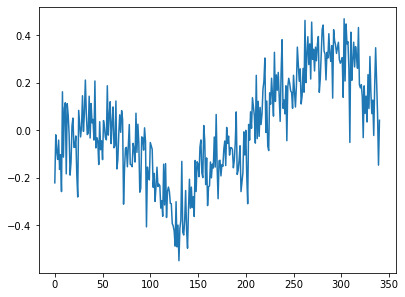

noise_0.5


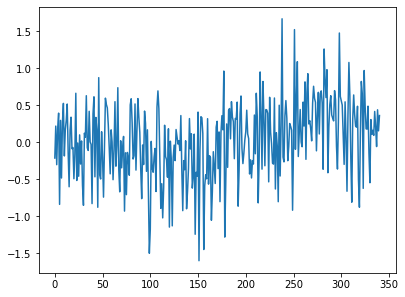

noise_1


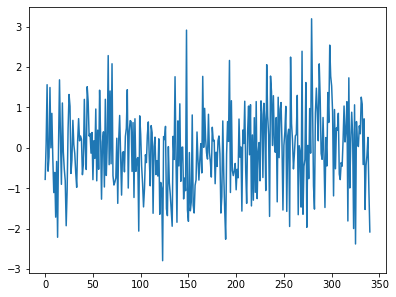

noise_1.5


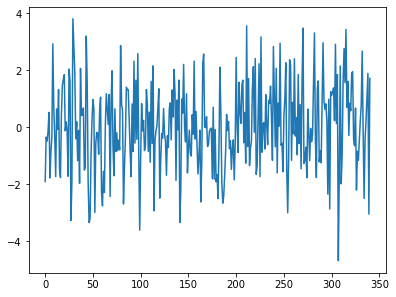

In [56]:
for noise, noise_name in zip(noises, noise_names):
    
    print(noise_name)
    
    data_HNN_noise = data_HNN + noise
    plt.plot(data_HNN_noise.flatten().T)
    plt.show()

noise_0


  0%|          | 0/500 [00:00<?, ?it/s]

noise_0.001


  0%|          | 0/500 [00:00<?, ?it/s]

noise_0.01


  0%|          | 0/500 [00:00<?, ?it/s]

noise_0.1


  0%|          | 0/500 [00:00<?, ?it/s]

noise_0.5


  0%|          | 0/500 [00:00<?, ?it/s]

noise_1


  0%|          | 0/500 [00:00<?, ?it/s]

noise_1.5


  0%|          | 0/500 [00:00<?, ?it/s]

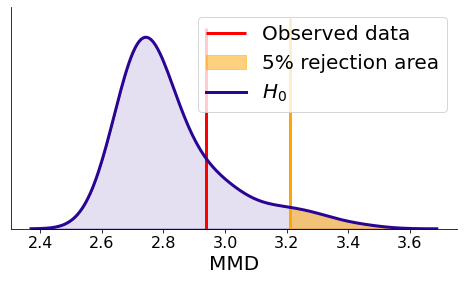

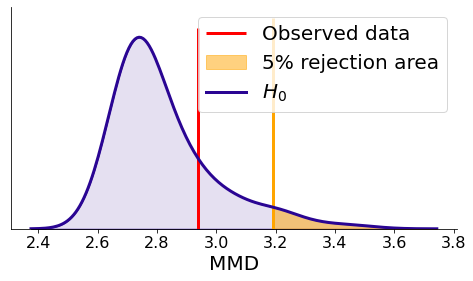

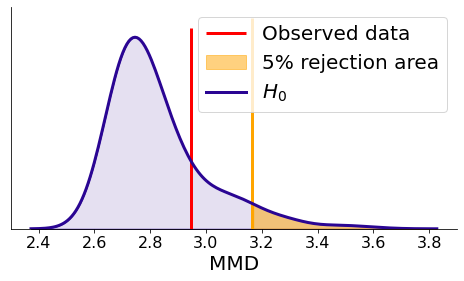

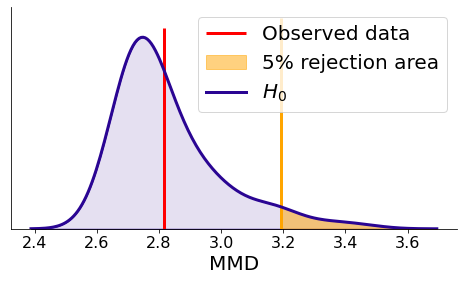

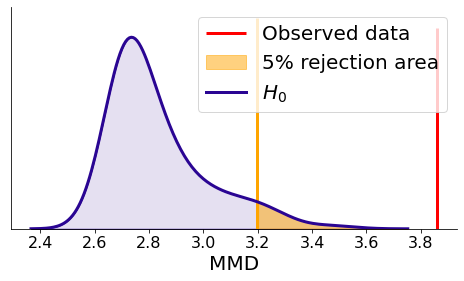

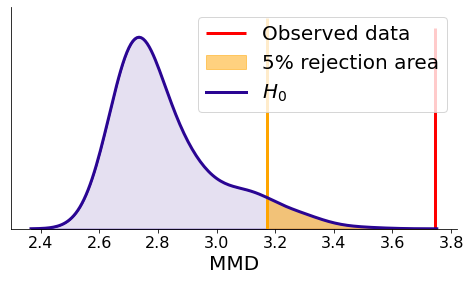

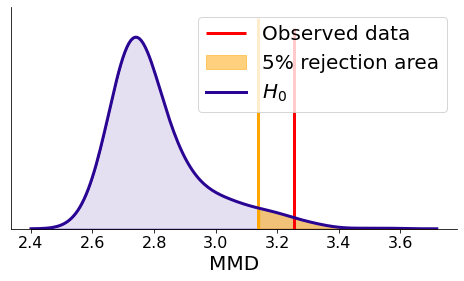

In [57]:
for noise, noise_name in zip(noises, noise_names):
    
    print(noise_name)
    
    data_HNN_noise = data_HNN + noise
    # plt.plot(data_HNN_noise.flatten().T)
    # plt.show()
    
    observed_data_HNN_noise = {}
    observed_data_HNN_noise['summary_conditions'] = data_HNN_noise
    observed_data_HNN_noise['direct_conditions'] = None
    observed_data_HNN_noise['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])
    
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(observed_data_HNN_noise, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True)
    _ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
    

#     plt.savefig(f'hypothesis_test_figures/real_obv_with{noise_name}.png')
    # plt.close()

## Real ERP data from HNN-GUI example

In [58]:
# 1000 simulated data

ori_x = torch.load('Aug15_data1000_3ERPDrives_no_preprocessing/x.pt')
ori_theta = torch.load('Aug15_data1000_3ERPDrives_no_preprocessing/theta.pt')

In [59]:
ori_x = np.array(ori_x)
ori_theta = np.array(ori_theta)

In [60]:
ori_x.shape

(1000, 341)

In [61]:
# Preprocess the 1000 simulated data

# scale
ori_x = ori_x * 3000

# Center time series by taking the “grand mean” (mean of all entries in matrix) and subtract from each row
avg = np.mean(ori_x)
ori_x = ori_x - avg

# Divide entire matrix by maximum of absolute value
maxAbs = np.max(np.abs(ori_x))
ori_x = ori_x / maxAbs

# Smoothing
for i in range(len(ori_x)):
    ori_x[i] = smooth_waveform(ori_x[i], window_len=30, sfreq=1000.0 / 0.5)

In [62]:
avg_x = np.mean(ori_x, axis=0)
avg_x.shape

(341,)

In [63]:
# Real ERP data from HNN-GUI example

yes_data = torch.load('Real_ERP_data/np_yes_data.pt')
no_data = torch.load('Real_ERP_data/np_no_data.pt')

In [64]:
# Preprocess the real ERP data from HNN-GUI example

# Divide the experimental data by the scaling factor
# yes_data = yes_data / 3000
# no_data = no_data / 3000

# Center time series by taking the “grand mean” (mean of all entries in matrix) and subtract from each row
yes_data = yes_data - avg
no_data = no_data - avg

# Divide entire matrix by maximum of absolute value
yes_data = yes_data / maxAbs
no_data = no_data / maxAbs

# # Smoothing
# for i in range(len(ori_x)):
#     ori_x[i] = smooth_waveform(ori_x[i], window_len=30, sfreq=1000.0 / 0.5)

In [65]:
yes_data.shape

(341,)

In [66]:
yes_data_reshaped = yes_data.reshape(1, 1, 341)
no_data_reshaped = no_data.reshape(1, 1, 341)

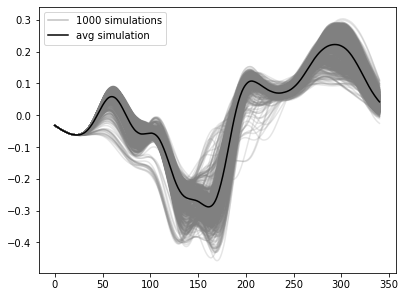

In [67]:
plt.plot(ori_x.T, color='gray', alpha=0.2)
plt.plot([], color='gray', alpha=0.5, label='1000 simulations')  #just for legend setting purpose
plt.plot(avg_x.T, color='black', label="avg simulation")
# plt.plot(yes_data.T, color='red', label="yes_trial_S1_ERP_all_avg")
# plt.plot(no_data.T, color='blue', label="no_trial_S1_ERP_all_avg")
plt.legend()
plt.show()

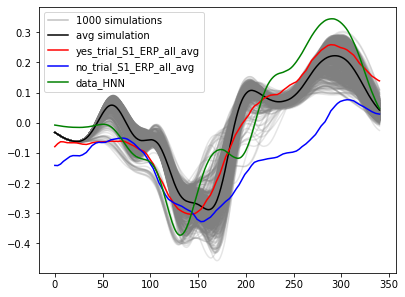

In [68]:
plt.plot(ori_x.T, color='gray', alpha=0.2)
plt.plot([], color='gray', alpha=0.5, label='1000 simulations')  #just for legend setting purpose
plt.plot(avg_x.T, color='black', label="avg simulation")
plt.plot(yes_data.T, color='red', label="yes_trial_S1_ERP_all_avg")
plt.plot(no_data.T, color='blue', label="no_trial_S1_ERP_all_avg")
plt.plot(data_HNN.flatten().T, color='green', label="data_HNN")
plt.legend()
plt.show()

In [69]:
# yes_trial_S1_ERP_all_avg.txt
data_ERP_yes = yes_data_reshaped
observed_data_ERP_yes = {}
observed_data_ERP_yes['summary_conditions'] = data_ERP_yes
observed_data_ERP_yes['direct_conditions'] = None
# observed_data_ERP_yes['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])
# observed_data_ERP_yes['parameters'] = None

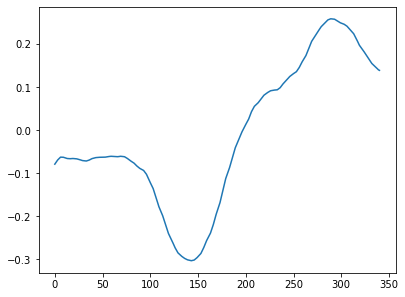

In [70]:
plt.plot(data_ERP_yes.flatten().T)
plt.show()

In [71]:
summary_statistics = trainer.amortizer.summary_net(x)
summary_statistics_yes = trainer.amortizer.summary_net(data_ERP_yes)

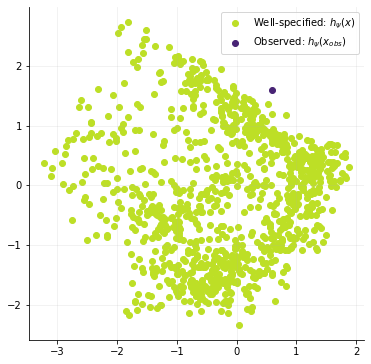

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = cm.viridis(np.linspace(0.1, 0.9, 2))
ax.scatter(summary_statistics[:, 0], summary_statistics[:, 1], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
ax.scatter(
    summary_statistics_yes[:, 0], summary_statistics_yes[:, 1], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
)
ax.legend()
ax.grid(alpha=0.2)
plt.gca().set_aspect("equal")
sns.despine(ax=ax)

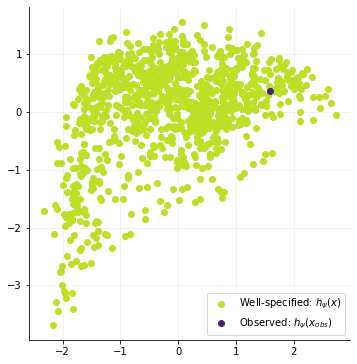

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = cm.viridis(np.linspace(0.1, 0.9, 2))
ax.scatter(summary_statistics[:, 1], summary_statistics[:, 2], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
ax.scatter(
    summary_statistics_yes[:, 1], summary_statistics_yes[:, 2], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
)
ax.legend()
ax.grid(alpha=0.2)
plt.gca().set_aspect("equal")
sns.despine(ax=ax)

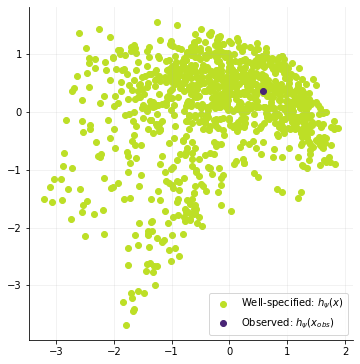

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = cm.viridis(np.linspace(0.1, 0.9, 2))
ax.scatter(summary_statistics[:, 0], summary_statistics[:, 2], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
ax.scatter(
    summary_statistics_yes[:, 0], summary_statistics_yes[:, 2], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
)
ax.legend()
ax.grid(alpha=0.2)
plt.gca().set_aspect("equal")
sns.despine(ax=ax)

  0%|          | 0/500 [00:00<?, ?it/s]

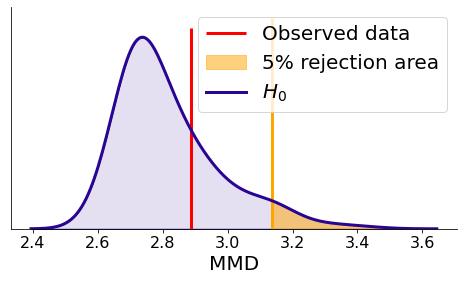

In [75]:
MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data_ERP_yes, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

In [76]:
# no_trial_S1_ERP_all_avg.txt
data_ERP_no = no_data_reshaped
observed_data_ERP_no = {}
observed_data_ERP_no['summary_conditions'] = data_ERP_no
observed_data_ERP_no['direct_conditions'] = None
# observed_data_ERP_no['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])
# observed_data_ERP_no['parameters'] = None

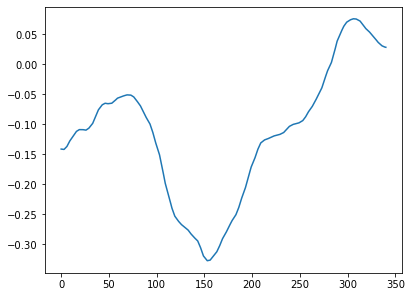

In [77]:
plt.plot(data_ERP_no.flatten().T)
plt.show()

In [78]:
summary_statistics = trainer.amortizer.summary_net(x)
summary_statistics_no = trainer.amortizer.summary_net(data_ERP_no)

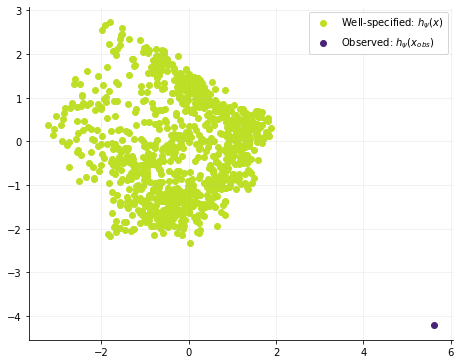

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = cm.viridis(np.linspace(0.1, 0.9, 2))
ax.scatter(summary_statistics[:, 0], summary_statistics[:, 1], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
ax.scatter(
    summary_statistics_no[:, 0], summary_statistics_no[:, 1], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
)
ax.legend()
ax.grid(alpha=0.2)
plt.gca().set_aspect("equal")
sns.despine(ax=ax)

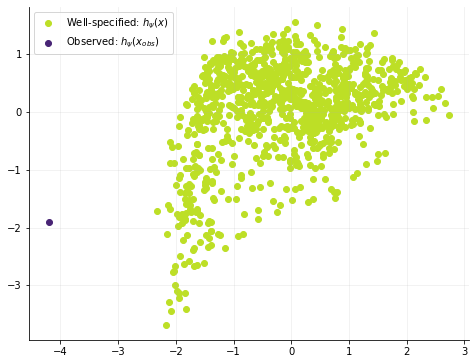

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = cm.viridis(np.linspace(0.1, 0.9, 2))
ax.scatter(summary_statistics[:, 1], summary_statistics[:, 2], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
ax.scatter(
    summary_statistics_no[:, 1], summary_statistics_no[:, 2], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
)
ax.legend()
ax.grid(alpha=0.2)
plt.gca().set_aspect("equal")
sns.despine(ax=ax)

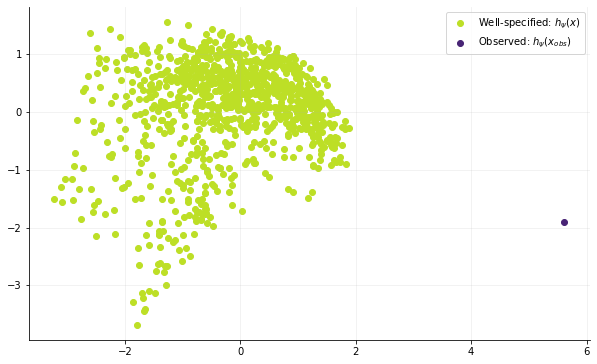

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = cm.viridis(np.linspace(0.1, 0.9, 2))
ax.scatter(summary_statistics[:, 0], summary_statistics[:, 2], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
ax.scatter(
    summary_statistics_no[:, 0], summary_statistics_no[:, 2], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
)
ax.legend()
ax.grid(alpha=0.2)
plt.gca().set_aspect("equal")
sns.despine(ax=ax)

  0%|          | 0/500 [00:00<?, ?it/s]

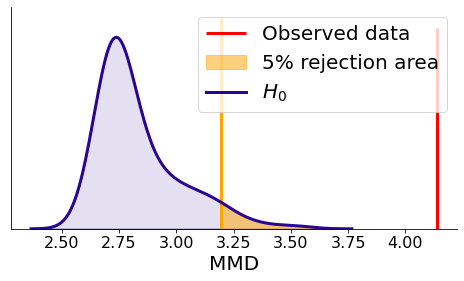

In [82]:
MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data_ERP_no, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

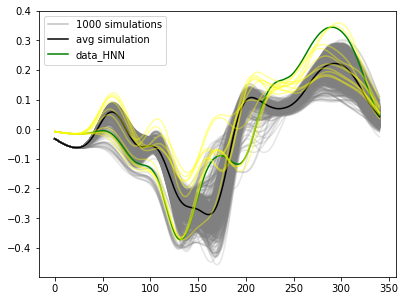

In [83]:
plt.plot(ori_x.T, color='gray', alpha=0.2)
plt.plot([], color='gray', alpha=0.5, label='1000 simulations')  #just for legend setting purpose
plt.plot(avg_x.T, color='black', label="avg simulation")
# plt.plot(yes_data.T, color='red', label="yes_trial_S1_ERP_all_avg")
# plt.plot(no_data.T, color='blue', label="no_trial_S1_ERP_all_avg")
plt.plot(data_HNN.flatten().T, color='green', label="data_HNN")
plt.plot(ten_data_HNN.reshape(10,341).T, color='yellow', alpha=0.4)
plt.legend()
plt.show()